In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from utils.configure_results import configure_output_path, configure_result
from utils.ebcm import degree_distribution, SemiDirectedDegreeFactorized, EBCMSemiDirectedConfig, SemiDirectedSAREBCM, simulate_ebcm

from tqdm import tqdm

# グラフの色指定
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
markers = ["o", "^", "s", "D", "P", "X", "d", "H", "v", "p", "*"]
linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]

# グラフ全体のフォント設定
# plt.rcParams['font.family'] = 'serif'  # 全体のフォントをSerifに設定
# plt.rcParams['mathtext.fontset'] = 'cm'  # 数式のフォントをComputer Modernに設定
# plt.rcParams['mathtext.rm'] = 'serif'  # TeXの通常フォントをSerifに設定
# plt.rcParams['font.size'] = 18  # デフォルトフォントサイズ
# plt.rcParams['axes.labelsize'] = 18  # 軸ラベルのフォントサイズ
# plt.rcParams['axes.titlesize'] = 22  # タイトルのフォントサイズ
# plt.rcParams['legend.fontsize'] = 16  # 凡例のフォントサイズ
# plt.rcParams['grid.color'] = 'gray'  # グリッドの色を薄い灰色に設定
# plt.rcParams['grid.linestyle'] = ':'  # グリッドを点線に設定
# plt.rcParams['grid.linewidth'] = 0.5  # グリッドの線幅を設定

In [2]:
N = 100000
pk_in = degree_distribution("poisson", N=N, k_ave=10)
pk_out = degree_distribution("power_law", N=N, k_ave=10, gamma=2.7, k_min=1)
pk_und = degree_distribution("poisson", N=N, k_ave=10)

deg = SemiDirectedDegreeFactorized(pk_in=pk_in, pk_out=pk_out, pk_und=pk_und)

rho0_min = 0.0
rho0_max = 0.2
drho0 = 0.005
rho0_values = np.arange(rho0_min, rho0_max + drho0, drho0)

lambda_d_min = 0.0
lambda_d_max = 2.0
dlambda_d = 0.05
lambda_d_values = np.arange(lambda_d_min, lambda_d_max + dlambda_d, dlambda_d)

lambda_u_min = 0.0
lambda_u_max = 1.0
dlambda_u = 0.01
lambda_u_values = np.array([0.0, 0.5, 1.0])
# lambda_u_values = np.arange(lambda_u_min, lambda_u_max, dlambda_u)

In [3]:
def run_one(i, j, k):
    rho0 = float(rho0_values[i])
    lambda_d = float(lambda_d_values[j])
    lambda_u = float(lambda_u_values[k])

    cfg = EBCMSemiDirectedConfig(
        rho0=rho0, mu=1.0, T=3,
        lambda_d=lambda_d, lambda_u=lambda_u,
        deg_factorized=deg,
    )
    model = SemiDirectedSAREBCM(cfg)
    out = simulate_ebcm(model, t_max=100.0, dt=0.01)

    return i, j, k, out


tasks = [(i, j, k)
         for i in range(len(rho0_values))
         for j in range(len(lambda_d_values))
         for k in range(len(lambda_u_values))]

shape = (len(rho0_values), len(lambda_d_values), len(lambda_u_values))
out_all = np.empty(shape, dtype=object)

results = Parallel(n_jobs=-1)(
    delayed(run_one)(i, j, k)
    for (i, j, k) in tqdm(tasks)
)

# ここで results は list になっているはず
for i, j, k, out in results:
    out_all[i, j, k] = out

100%|██████████| 5043/5043 [18:54<00:00,  4.44it/s]


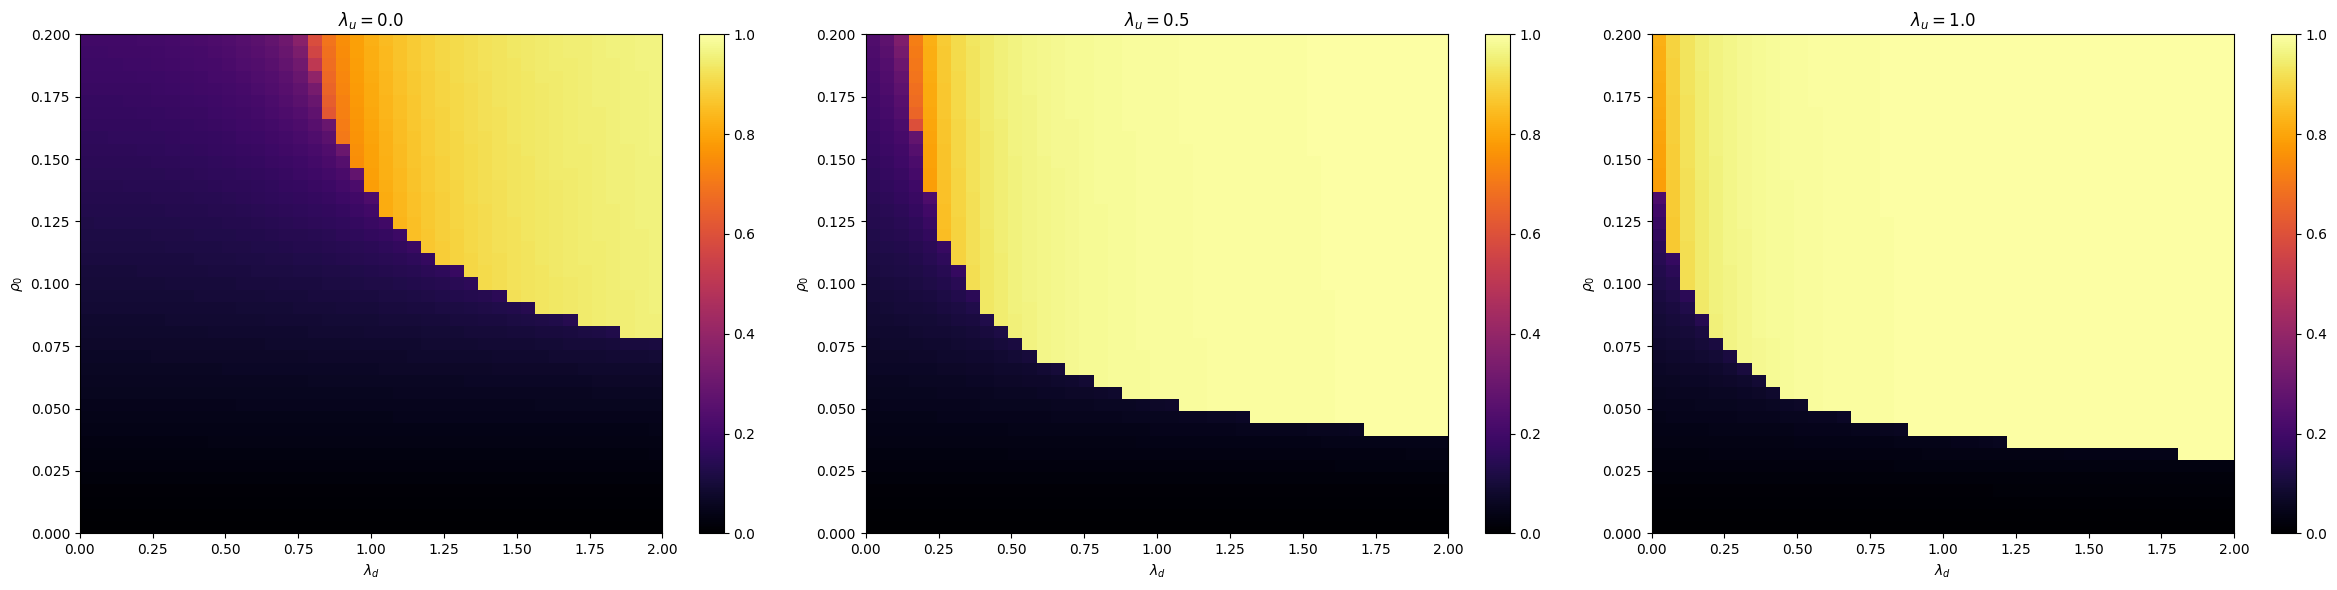

In [4]:
fig, axes = plt.subplots(1, len(lambda_u_values), figsize=(8*len(lambda_u_values), 6))

for k, lambda_u in enumerate(lambda_u_values):
    ax = axes[k]

    R = np.zeros((len(rho0_values), len(lambda_d_values)), dtype=float)

    for i, rho0 in enumerate(rho0_values):
        for j, lambda_d in enumerate(lambda_d_values):
            R[i, j] = out_all[i, j, k]["R"][-1]

    im = ax.imshow(
        R,
        aspect="auto",
        origin="lower",
        extent=[
            lambda_d_values[0],
            lambda_d_values[-1],
            rho0_values[0],
            rho0_values[-1],
        ],
        vmin=0.0,
        vmax=1.0,
        cmap="inferno",
    )

    fig.colorbar(im, ax=ax)

    ax.set_xlabel(r"$\lambda_d$")
    ax.set_ylabel(r"$\rho_0$")
    ax.set_title(rf"$\lambda_u = {lambda_u}$")

plt.tight_layout()
plt.show()
